# Impact d'événements disruptifs sur le marché

On considère 5 évènements disruptifs majeurs :

1. Catastrophe naturelle :
Incendies en Californie - 8 novembre 2018 (début)

2. Evenement sectoriel :
Scandale des opioïdes (Purdue Pharma & Big Pharma) - 25 octobre 2017 (premier procès d'État majeur contre les fabricants d’opioïdes)

3. Evenement entreprise :
Apple : Publication résultats Q4 catastrophiques - 2 janvier 2019

4. Evenement mondial :
Invasion de l’Ukraine par la Russie - 24 février 2022 (début officiel à l’aube)

5. Evenement politique :
Brexit / Référendum UK - 23 juin 2016

On cherche à faire des statistiques descriptives pour mesurer l'impact de ces événements sur le marché.

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Pour cette section, les seules données requises sont les données Yahoo Finance S&P 500 auxquelles on a ajouté les features.

In [3]:
df = pd.read_csv(r"C:\Users\lloyd\OneDrive\Documents\Projet python\data\dataset_with_feature.csv")

On précise le secteur auquel appartient chaque entreprise

In [4]:
import requests

url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
headers = {"User-Agent": "Mozilla/5.0"}

resp = requests.get(url, headers=headers)
resp.raise_for_status()  # lève une erreur si 4xx/5xx

tables = pd.read_html(resp.text, header=0)
sp500 = tables[0]

sp500 = sp500.rename(columns={"Symbol": "Ticker", "GICS Sector": "Sector"})
sp500['Ticker'] = sp500['Ticker'].str.replace('.', '-', regex=False)

df = df.sort_values(by=['Ticker', 'Date'])

df = df.merge(
    sp500[['Ticker', 'Sector']], 
    on='Ticker', 
    how='left'
)


# code repris de description_2

C:\Users\lloyd\AppData\Local\Temp\ipykernel_20724\131376753.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  tables = pd.read_html(resp.text, header=0)


In [6]:
df['Sector'].unique()

array(['Health Care', 'Information Technology', 'Financials',
       'Consumer Staples', 'Industrials', 'Utilities', 'Materials',
       'Real Estate', 'Consumer Discretionary', 'Energy',
       'Communication Services', nan], dtype=object)

In [5]:
df['Date']  = pd.to_datetime(df['Date'])

I. Incendies en Californie

In [ ]:
date_event = pd.to_datetime('2018-11-08')

df_event = df[(df['Date'] >= date_event - pd.Timedelta(days=15)) & (df['Date'] <= date_event + pd.Timedelta(days=15))].copy()

La plupart des entreprises sont localisées aux Etats-Unis, on va observer les résultats pour les entreprises nord-américaines et les autres.

In [19]:
non_na_sp500_ticker = [
    'ACN',
    'ALLE',
    'AMCR',
    'AON',
    'APTV',
    'CB',
    'ETN',
    'GRMN',
    'JCI',
    'LIN',
    'LYB',
    'MDT',
    'NXPI',
    'PNR',
    'STX',
    'SW',
    'STE',
    'TEL',
    'TT',
    'WTW'
]

df_na = df_event[~df_event['Ticker'].isin(non_na_sp500_ticker)].copy()
df_non_na = df_event[df_event['Ticker'].isin(non_na_sp500_ticker)].copy()  

1. Returns

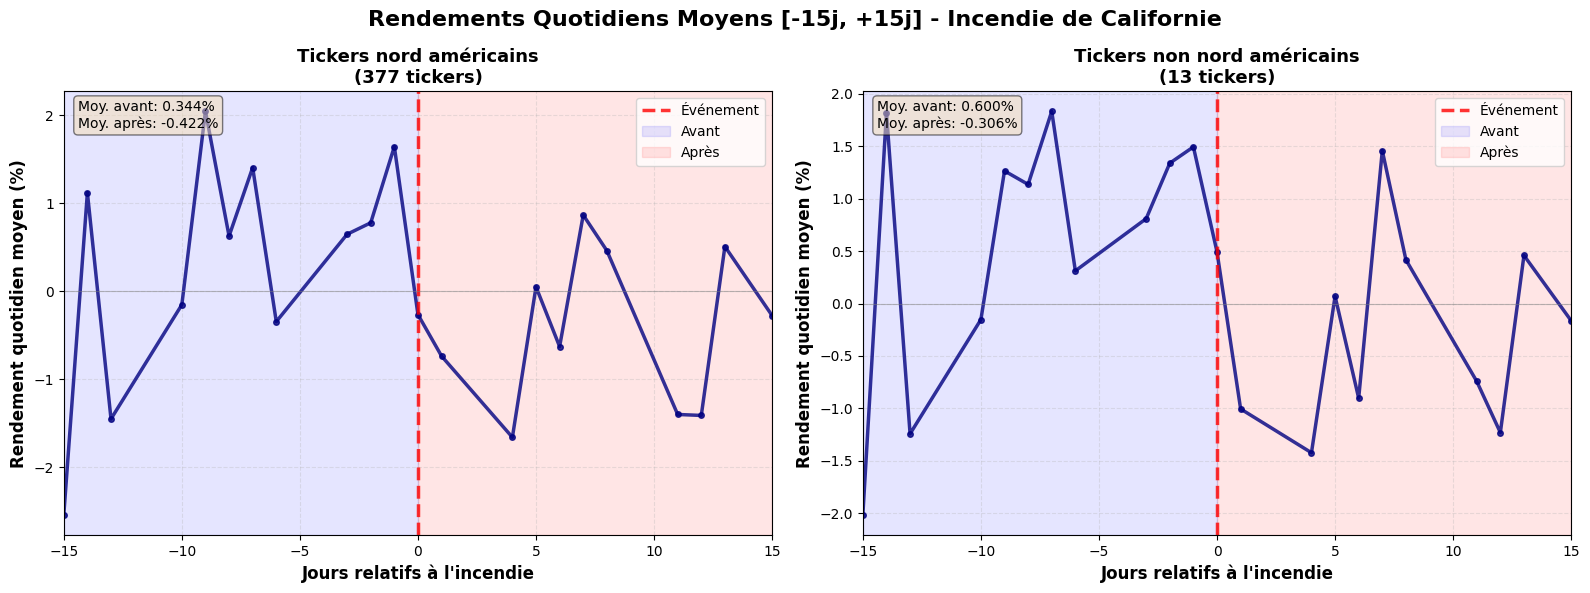

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Calculer les rendements quotidiens moyens pour chaque groupe
for idx, (df_subset, label, ax) in enumerate([
    (df_na, 'Tickers nord américains', axes[0]),
    (df_non_na, 'Tickers non nord américains', axes[1])
]):
    # Grouper par date et calculer la moyenne des rendements
    daily_avg_returns = df_subset.groupby('Date')['R1J'].mean() * 100
    
    # Créer un index de jours relatifs à l'événement
    dates = daily_avg_returns.index.sort_values()
    days_relative = [(d - date_event).days for d in dates]
    
    # Tracer la courbe
    ax.plot(days_relative, daily_avg_returns.loc[dates].values, 
        linewidth=2.5, color='navy', marker='o', markersize=4, alpha=0.8)
    
    # Ligne verticale pour l'événement
    ax.axvline(x=0, color='red', linestyle='--', linewidth=2.5, 
            label='Événement', alpha=0.8)
    
    # Ligne horizontale à 0
    ax.axhline(y=0, color='gray', linestyle='-', linewidth=0.8, alpha=0.5)
    
    # Zones avant/après colorées
    ax.axvspan(-15, 0, alpha=0.1, color='blue', label='Avant')
    ax.axvspan(0, 15, alpha=0.1, color='red', label='Après')
    
    # Labels et titre
    ax.set_xlabel('Jours relatifs à l\'incendie', fontsize=12, fontweight='bold')
    ax.set_ylabel('Rendement quotidien moyen (%)', fontsize=12, fontweight='bold')
    ax.set_title(f'{label}\n({len(df_subset["Ticker"].unique())} tickers)', 
                fontsize=13, fontweight='bold')
    
    # Grille et légende
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.legend(loc='best', fontsize=10)
    
    # Limites de l'axe X
    ax.set_xlim(-15, 15)
    
    # Ajouter les statistiques sur le graphique
    mean_before = df_subset[df_subset['Date'] < date_event]['R1J'].mean() * 100
    mean_after = df_subset[df_subset['Date'] > date_event]['R1J'].mean() * 100
    
    stats_text = f'Moy. avant: {mean_before:.3f}%\nMoy. après: {mean_after:.3f}%'
    ax.text(0.02, 0.98, stats_text, transform=ax.transAxes,
        fontsize=10, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Titre général
fig.suptitle(f'Rendements Quotidiens Moyens [-15j, +15j] - {'Incendie de Californie'}',
            fontsize=16, fontweight='bold', y=0.98)

plt.tight_layout()

2. Volatilité

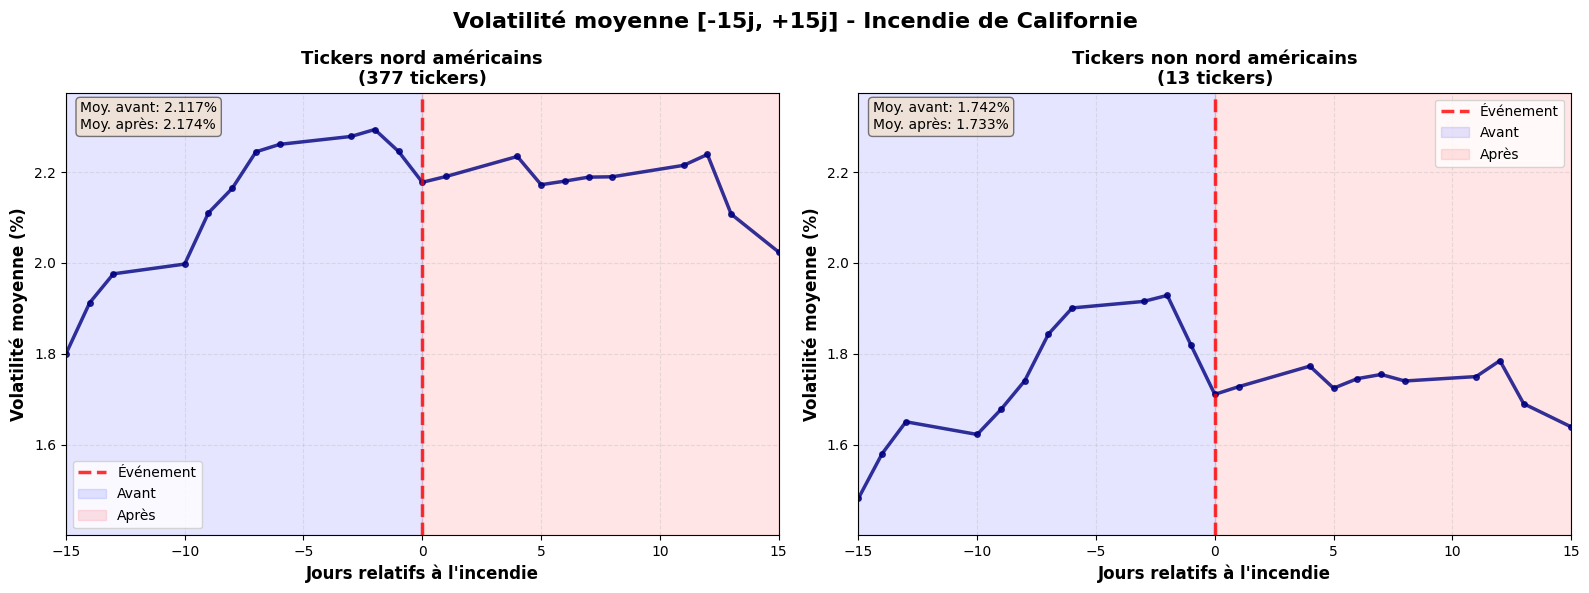

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Stocker les valeurs min/max pour synchroniser les échelles
all_values = []

# Calculer les rendements quotidiens moyens pour chaque groupe
for idx, (df_subset, label, ax) in enumerate([
    (df_na, 'Tickers nord américains', axes[0]),
    (df_non_na, 'Tickers non nord américains', axes[1])
]):
    # Grouper par date et calculer la moyenne des rendements
    daily_avg_volatility = df_subset.groupby('Date')['Volatilite 20J'].mean() * 100
    
    # Stocker les valeurs pour calculer l'échelle globale
    all_values.extend(daily_avg_volatility.values)
    
    # Créer un index de jours relatifs à l'événement
    dates = daily_avg_volatility.index.sort_values()
    days_relative = [(d - date_event).days for d in dates]
    
    # Tracer la courbe
    ax.plot(days_relative, daily_avg_volatility.loc[dates].values, 
        linewidth=2.5, color='navy', marker='o', markersize=4, alpha=0.8)
    
    # Ligne verticale pour l'événement
    ax.axvline(x=0, color='red', linestyle='--', linewidth=2.5, 
            label='Événement', alpha=0.8)
    
    # Ligne horizontale à 0 (retirée car volume ne peut être négative)
    # ax.axhline(y=0, color='gray', linestyle='-', linewidth=0.8, alpha=0.5)
    
    # Zones avant/après colorées
    ax.axvspan(-15, 0, alpha=0.1, color='blue', label='Avant')
    ax.axvspan(0, 15, alpha=0.1, color='red', label='Après')
    
    # Labels et titre
    ax.set_xlabel('Jours relatifs à l\'incendie', fontsize=12, fontweight='bold')
    ax.set_ylabel('Volatilité moyenne (%)', fontsize=12, fontweight='bold')
    ax.set_title(f'{label}\n({len(df_subset["Ticker"].unique())} tickers)', 
                fontsize=13, fontweight='bold')
    
    # Grille et légende
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.legend(loc='best', fontsize=10)
    
    # Limites de l'axe X
    ax.set_xlim(-15, 15)
    
    # Ajouter les statistiques sur le graphique
    mean_before = df_subset[df_subset['Date'] < date_event]['Volatilite 20J'].mean() * 100
    mean_after = df_subset[df_subset['Date'] > date_event]['Volatilite 20J'].mean() * 100
    
    stats_text = f'Moy. avant: {mean_before:.3f}%\nMoy. après: {mean_after:.3f}%'
    ax.text(0.02, 0.98, stats_text, transform=ax.transAxes,
        fontsize=10, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# === SYNCHRONISER L'ÉCHELLE Y DES DEUX GRAPHIQUES ===
# Calculer les limites communes
y_min = min(all_values)
y_max = max(all_values)
y_margin = (y_max - y_min) * 0.1  # Ajouter 10% de marge

# Appliquer la même échelle aux deux graphiques
for ax in axes:
    ax.set_ylim(y_min - y_margin, y_max + y_margin)

# Titre général
fig.suptitle(f'Volatilité moyenne [-15j, +15j] - Incendie de Californie',
            fontsize=16, fontweight='bold', y=0.98)

plt.tight_layout()

3. Volume

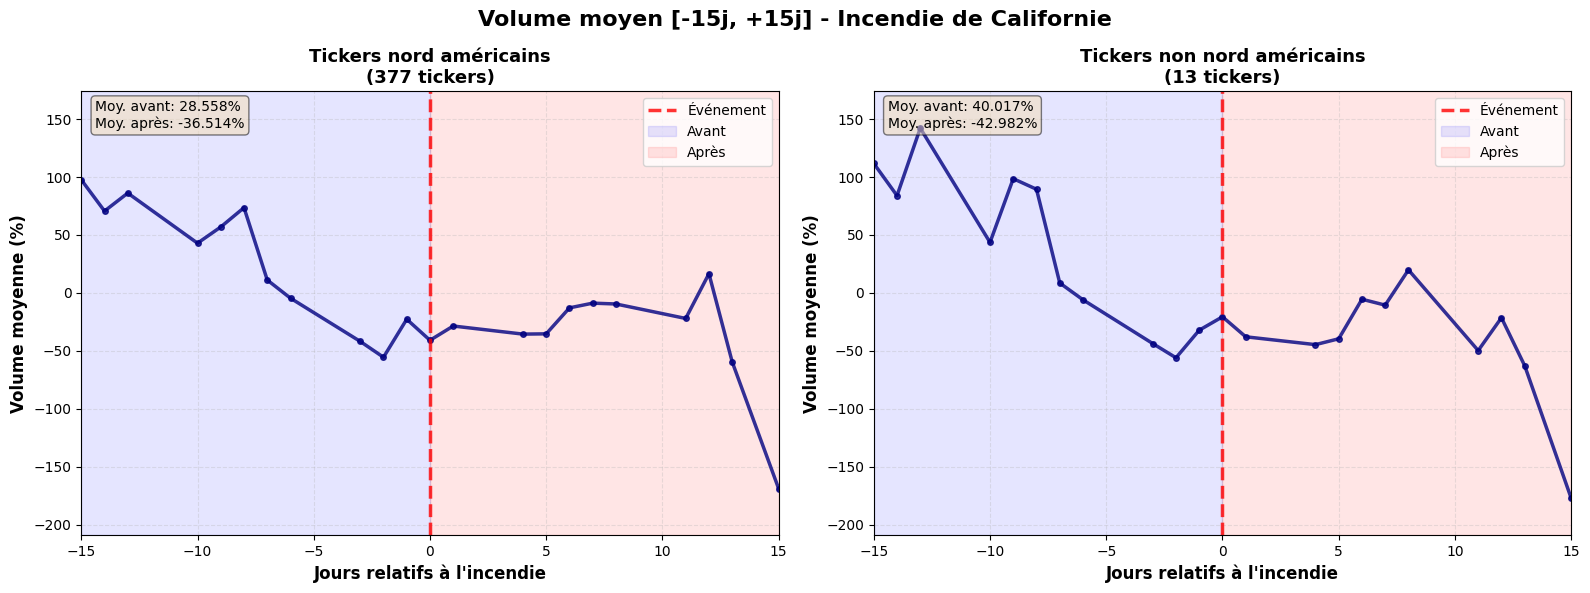

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Stocker les valeurs min/max pour synchroniser les échelles
all_values = []

# Calculer les rendements quotidiens moyens pour chaque groupe
for idx, (df_subset, label, ax) in enumerate([
    (df_na, 'Tickers nord américains', axes[0]),
    (df_non_na, 'Tickers non nord américains', axes[1])
]):
    # Grouper par date et calculer la moyenne des rendements
    daily_avg_volume = df_subset.groupby('Date')['volume_zscore'].mean() * 100
    
    # Stocker les valeurs pour calculer l'échelle globale
    all_values.extend(daily_avg_volume.values)
    
    # Créer un index de jours relatifs à l'événement
    dates = daily_avg_volume.index.sort_values()
    days_relative = [(d - date_event).days for d in dates]
    
    # Tracer la courbe
    ax.plot(days_relative, daily_avg_volume.loc[dates].values, 
        linewidth=2.5, color='navy', marker='o', markersize=4, alpha=0.8)
    
    # Ligne verticale pour l'événement
    ax.axvline(x=0, color='red', linestyle='--', linewidth=2.5, 
            label='Événement', alpha=0.8)
    
    # Ligne horizontale à 0 (retirée car volume ne peut être négative)
    # ax.axhline(y=0, color='gray', linestyle='-', linewidth=0.8, alpha=0.5)
    
    # Zones avant/après colorées
    ax.axvspan(-15, 0, alpha=0.1, color='blue', label='Avant')
    ax.axvspan(0, 15, alpha=0.1, color='red', label='Après')
    
    # Labels et titre
    ax.set_xlabel('Jours relatifs à l\'incendie', fontsize=12, fontweight='bold')
    ax.set_ylabel('Volume moyenne (%)', fontsize=12, fontweight='bold')
    ax.set_title(f'{label}\n({len(df_subset["Ticker"].unique())} tickers)', 
                fontsize=13, fontweight='bold')
    
    # Grille et légende
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.legend(loc='best', fontsize=10)
    
    # Limites de l'axe X
    ax.set_xlim(-15, 15)
    
    # Ajouter les statistiques sur le graphique
    mean_before = df_subset[df_subset['Date'] < date_event]['volume_zscore'].mean() * 100
    mean_after = df_subset[df_subset['Date'] > date_event]['volume_zscore'].mean() * 100
    
    stats_text = f'Moy. avant: {mean_before:.3f}%\nMoy. après: {mean_after:.3f}%'
    ax.text(0.02, 0.98, stats_text, transform=ax.transAxes,
        fontsize=10, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# === SYNCHRONISER L'ÉCHELLE Y DES DEUX GRAPHIQUES ===
# Calculer les limites communes
y_min = min(all_values)
y_max = max(all_values)
y_margin = (y_max - y_min) * 0.1  # Ajouter 10% de marge

# Appliquer la même échelle aux deux graphiques
for ax in axes:
    ax.set_ylim(y_min - y_margin, y_max + y_margin)

# Titre général
fig.suptitle(f'Volume moyen [-15j, +15j] - Incendie de Californie',
            fontsize=16, fontweight='bold', y=0.98)

plt.tight_layout()

II. Scandale des opioïdes

In [11]:
date_event = pd.to_datetime('2017-10-25')

df_event = df[(df['Date'] >= date_event - pd.Timedelta(days=15)) & (df['Date'] <= date_event + pd.Timedelta(days=15))].copy()

On va comparer l'impact entre le secteur 'Health Care' et les autres secteurs.

In [12]:
df_hc = df_event[df_event['Sector'] == 'Health Care'].copy()
df_other = df_event[df_event['Sector'] != 'Health Care'].copy()

1. Returns

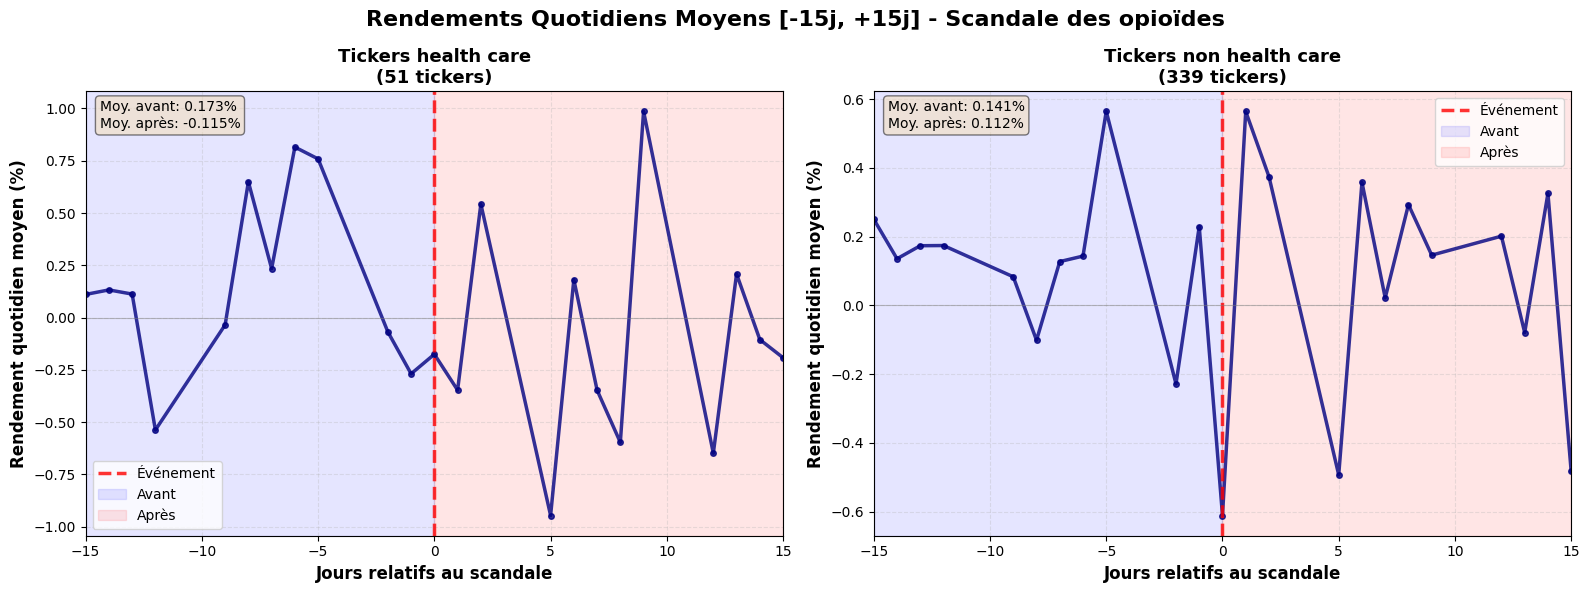

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Calculer les rendements quotidiens moyens pour chaque groupe
for idx, (df_subset, label, ax) in enumerate([
    (df_hc, 'Tickers health care', axes[0]),
    (df_other, 'Tickers non health care', axes[1])
]):
    # Grouper par date et calculer la moyenne des rendements
    daily_avg_returns = df_subset.groupby('Date')['R1J'].mean() * 100
    
    # Créer un index de jours relatifs à l'événement
    dates = daily_avg_returns.index.sort_values()
    days_relative = [(d - date_event).days for d in dates]
    
    # Tracer la courbe
    ax.plot(days_relative, daily_avg_returns.loc[dates].values, 
        linewidth=2.5, color='navy', marker='o', markersize=4, alpha=0.8)
    
    # Ligne verticale pour l'événement
    ax.axvline(x=0, color='red', linestyle='--', linewidth=2.5, 
            label='Événement', alpha=0.8)
    
    # Ligne horizontale à 0
    ax.axhline(y=0, color='gray', linestyle='-', linewidth=0.8, alpha=0.5)
    
    # Zones avant/après colorées
    ax.axvspan(-15, 0, alpha=0.1, color='blue', label='Avant')
    ax.axvspan(0, 15, alpha=0.1, color='red', label='Après')
    
    # Labels et titre
    ax.set_xlabel('Jours relatifs au scandale', fontsize=12, fontweight='bold')
    ax.set_ylabel('Rendement quotidien moyen (%)', fontsize=12, fontweight='bold')
    ax.set_title(f'{label}\n({len(df_subset["Ticker"].unique())} tickers)', 
                fontsize=13, fontweight='bold')
    
    # Grille et légende
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.legend(loc='best', fontsize=10)
    
    # Limites de l'axe X
    ax.set_xlim(-15, 15)
    
    # Ajouter les statistiques sur le graphique
    mean_before = df_subset[df_subset['Date'] < date_event]['R1J'].mean() * 100
    mean_after = df_subset[df_subset['Date'] > date_event]['R1J'].mean() * 100
    
    stats_text = f'Moy. avant: {mean_before:.3f}%\nMoy. après: {mean_after:.3f}%'
    ax.text(0.02, 0.98, stats_text, transform=ax.transAxes,
        fontsize=10, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Titre général
fig.suptitle(f'Rendements Quotidiens Moyens [-15j, +15j] - {'Scandale des opioïdes'}',
            fontsize=16, fontweight='bold', y=0.98)

plt.tight_layout()

2. Volatilité

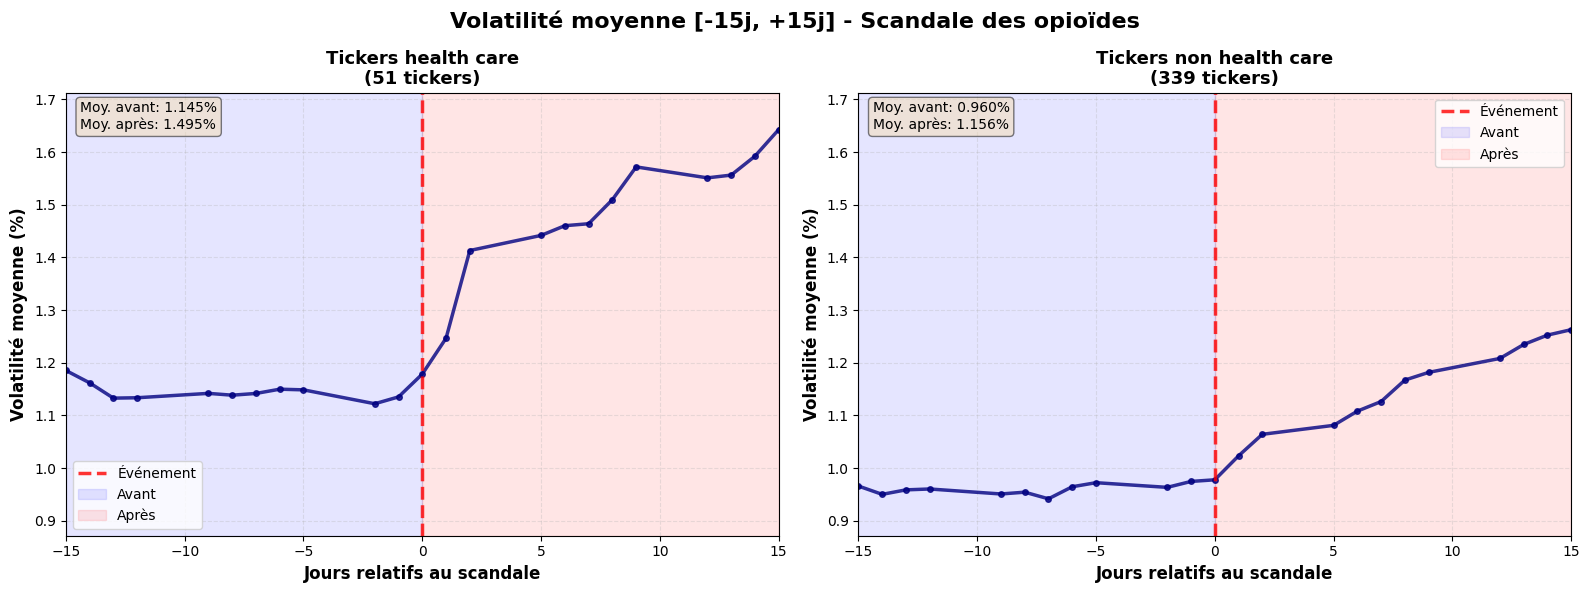

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Stocker les valeurs min/max pour synchroniser les échelles
all_values = []

# Calculer les rendements quotidiens moyens pour chaque groupe
for idx, (df_subset, label, ax) in enumerate([
    (df_hc, 'Tickers health care', axes[0]),
    (df_other, 'Tickers non health care', axes[1])
]):
    # Grouper par date et calculer la moyenne des rendements
    daily_avg_volatility = df_subset.groupby('Date')['Volatilite 20J'].mean() * 100
    
    # Stocker les valeurs pour calculer l'échelle globale
    all_values.extend(daily_avg_volatility.values)
    
    # Créer un index de jours relatifs à l'événement
    dates = daily_avg_volatility.index.sort_values()
    days_relative = [(d - date_event).days for d in dates]
    
    # Tracer la courbe
    ax.plot(days_relative, daily_avg_volatility.loc[dates].values, 
        linewidth=2.5, color='navy', marker='o', markersize=4, alpha=0.8)
    
    # Ligne verticale pour l'événement
    ax.axvline(x=0, color='red', linestyle='--', linewidth=2.5, 
            label='Événement', alpha=0.8)
    
    # Ligne horizontale à 0 (retirée car volume ne peut être négative)
    # ax.axhline(y=0, color='gray', linestyle='-', linewidth=0.8, alpha=0.5)
    
    # Zones avant/après colorées
    ax.axvspan(-15, 0, alpha=0.1, color='blue', label='Avant')
    ax.axvspan(0, 15, alpha=0.1, color='red', label='Après')
    
    # Labels et titre
    ax.set_xlabel('Jours relatifs au scandale', fontsize=12, fontweight='bold')
    ax.set_ylabel('Volatilité moyenne (%)', fontsize=12, fontweight='bold')
    ax.set_title(f'{label}\n({len(df_subset["Ticker"].unique())} tickers)', 
                fontsize=13, fontweight='bold')
    
    # Grille et légende
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.legend(loc='best', fontsize=10)
    
    # Limites de l'axe X
    ax.set_xlim(-15, 15)
    
    # Ajouter les statistiques sur le graphique
    mean_before = df_subset[df_subset['Date'] < date_event]['Volatilite 20J'].mean() * 100
    mean_after = df_subset[df_subset['Date'] > date_event]['Volatilite 20J'].mean() * 100
    
    stats_text = f'Moy. avant: {mean_before:.3f}%\nMoy. après: {mean_after:.3f}%'
    ax.text(0.02, 0.98, stats_text, transform=ax.transAxes,
        fontsize=10, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# === SYNCHRONISER L'ÉCHELLE Y DES DEUX GRAPHIQUES ===
# Calculer les limites communes
y_min = min(all_values)
y_max = max(all_values)
y_margin = (y_max - y_min) * 0.1  # Ajouter 10% de marge

# Appliquer la même échelle aux deux graphiques
for ax in axes:
    ax.set_ylim(y_min - y_margin, y_max + y_margin)

# Titre général
fig.suptitle(f'Volatilité moyenne [-15j, +15j] - Scandale des opioïdes',
            fontsize=16, fontweight='bold', y=0.98)

plt.tight_layout()

3. Volume

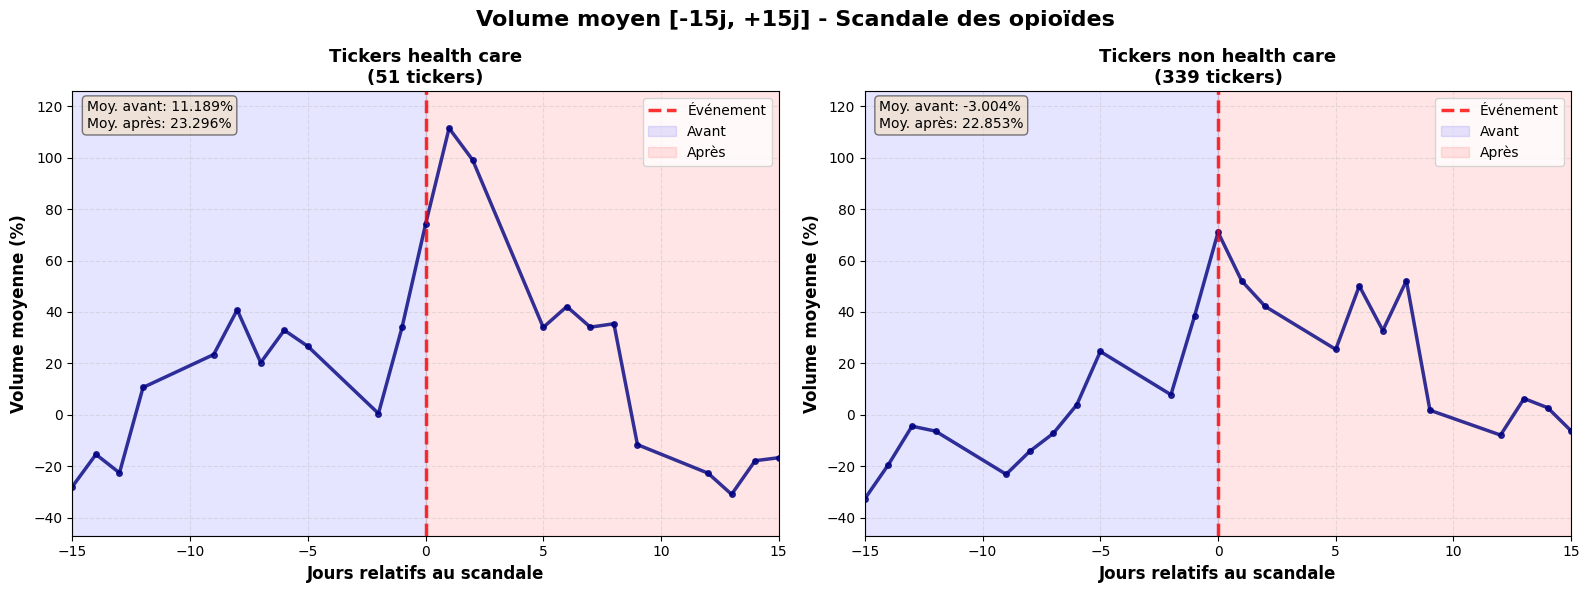

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Stocker les valeurs min/max pour synchroniser les échelles
all_values = []

# Calculer les rendements quotidiens moyens pour chaque groupe
for idx, (df_subset, label, ax) in enumerate([
    (df_hc, 'Tickers health care', axes[0]),
    (df_other, 'Tickers non health care', axes[1])
]):
    # Grouper par date et calculer la moyenne des rendements
    daily_avg_volume = df_subset.groupby('Date')['volume_zscore'].mean() * 100
    
    # Stocker les valeurs pour calculer l'échelle globale
    all_values.extend(daily_avg_volume.values)
    
    # Créer un index de jours relatifs à l'événement
    dates = daily_avg_volume.index.sort_values()
    days_relative = [(d - date_event).days for d in dates]
    
    # Tracer la courbe
    ax.plot(days_relative, daily_avg_volume.loc[dates].values, 
        linewidth=2.5, color='navy', marker='o', markersize=4, alpha=0.8)
    
    # Ligne verticale pour l'événement
    ax.axvline(x=0, color='red', linestyle='--', linewidth=2.5, 
            label='Événement', alpha=0.8)
    
    # Ligne horizontale à 0 (retirée car volume ne peut être négative)
    # ax.axhline(y=0, color='gray', linestyle='-', linewidth=0.8, alpha=0.5)
    
    # Zones avant/après colorées
    ax.axvspan(-15, 0, alpha=0.1, color='blue', label='Avant')
    ax.axvspan(0, 15, alpha=0.1, color='red', label='Après')
    
    # Labels et titre
    ax.set_xlabel('Jours relatifs au scandale', fontsize=12, fontweight='bold')
    ax.set_ylabel('Volume moyenne (%)', fontsize=12, fontweight='bold')
    ax.set_title(f'{label}\n({len(df_subset["Ticker"].unique())} tickers)', 
                fontsize=13, fontweight='bold')
    
    # Grille et légende
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.legend(loc='best', fontsize=10)
    
    # Limites de l'axe X
    ax.set_xlim(-15, 15)
    
    # Ajouter les statistiques sur le graphique
    mean_before = df_subset[df_subset['Date'] < date_event]['volume_zscore'].mean() * 100
    mean_after = df_subset[df_subset['Date'] > date_event]['volume_zscore'].mean() * 100
    
    stats_text = f'Moy. avant: {mean_before:.3f}%\nMoy. après: {mean_after:.3f}%'
    ax.text(0.02, 0.98, stats_text, transform=ax.transAxes,
        fontsize=10, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# === SYNCHRONISER L'ÉCHELLE Y DES DEUX GRAPHIQUES ===
# Calculer les limites communes
y_min = min(all_values)
y_max = max(all_values)
y_margin = (y_max - y_min) * 0.1  # Ajouter 10% de marge

# Appliquer la même échelle aux deux graphiques
for ax in axes:
    ax.set_ylim(y_min - y_margin, y_max + y_margin)

# Titre général
fig.suptitle(f'Volume moyen [-15j, +15j] - Scandale des opioïdes',
            fontsize=16, fontweight='bold', y=0.98)

plt.tight_layout()

III. Publication résultats Q4 catastrophiques d'Apple

In [19]:
date_event = pd.to_datetime('2019-01-02')

df_event = df[(df['Date'] >= date_event - pd.Timedelta(days=15)) & (df['Date'] <= date_event + pd.Timedelta(days=15))].copy()

Cette fois on s'intéresse à Apple, au secteur 'Information Technology' (excepté Apple) et aux autres.

In [20]:
df_apl = df_event[df_event['Ticker'] == 'AAPL'].copy()
df_it = df_event[(df_event['Sector'] == 'Information Technology') & (df_event['Ticker'] != 'AAPL')].copy()
df_other = df_event[df_event['Sector'] != 'Information Technology'].copy()

1. Returns

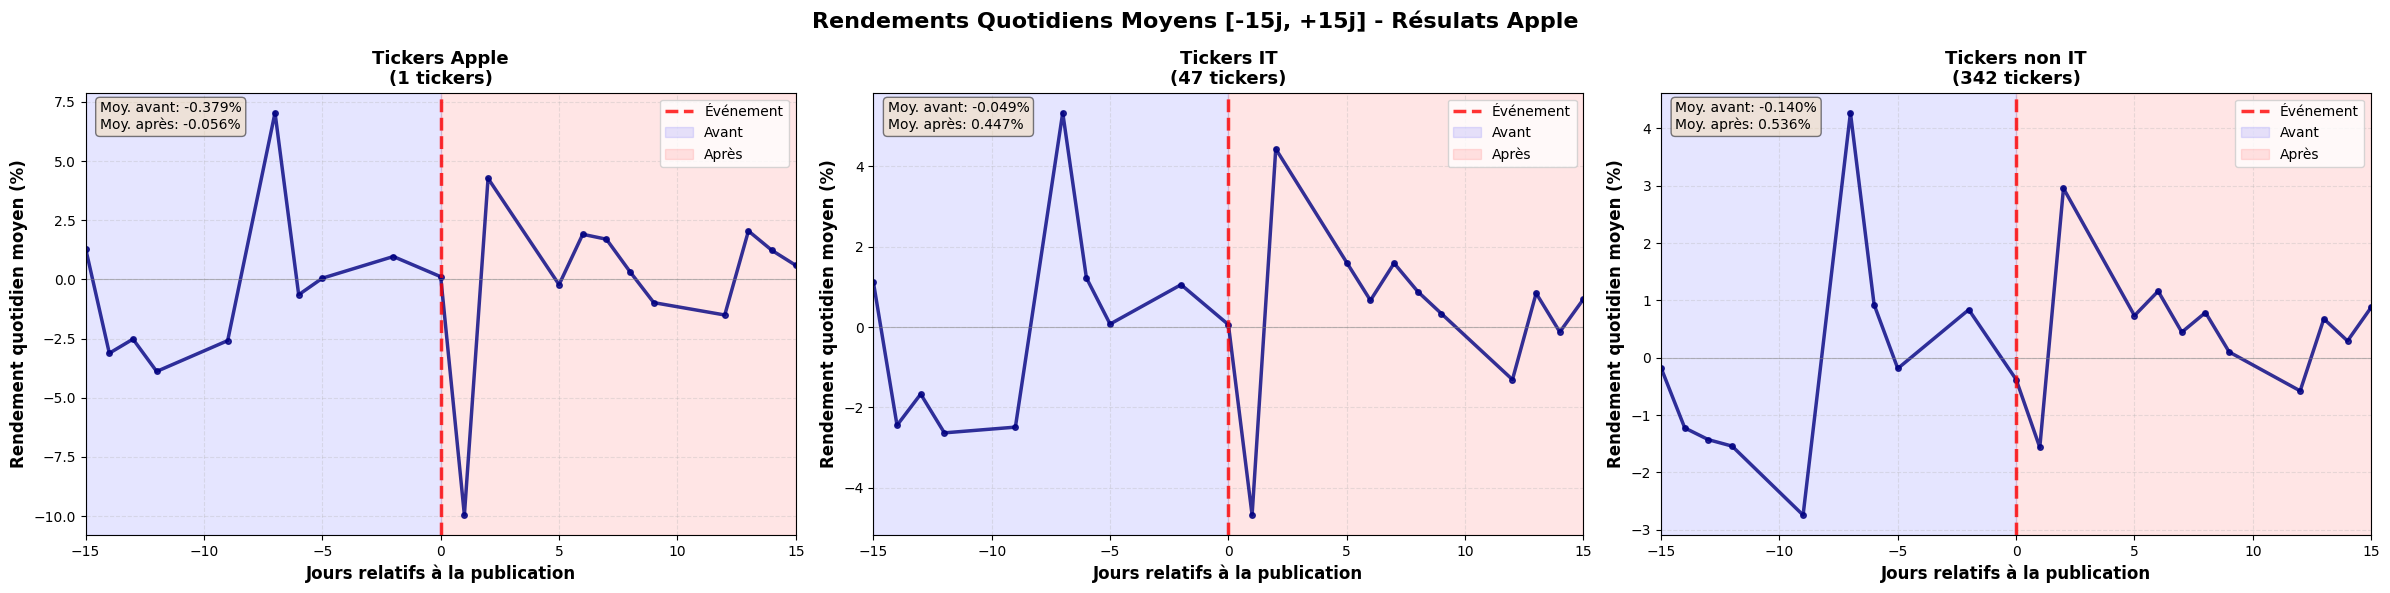

In [22]:
fig, axes = plt.subplots(1, 3, figsize=(24, 6))

# Calculer les rendements quotidiens moyens pour chaque groupe
for idx, (df_subset, label, ax) in enumerate([
    (df_apl, 'Tickers Apple', axes[0]),
    (df_it, 'Tickers IT', axes[1]),
    (df_other, 'Tickers non IT', axes[2])
]):
    # Grouper par date et calculer la moyenne des rendements
    daily_avg_returns = df_subset.groupby('Date')['R1J'].mean() * 100
    
    # Créer un index de jours relatifs à l'événement
    dates = daily_avg_returns.index.sort_values()
    days_relative = [(d - date_event).days for d in dates]
    
    # Tracer la courbe
    ax.plot(days_relative, daily_avg_returns.loc[dates].values, 
        linewidth=2.5, color='navy', marker='o', markersize=4, alpha=0.8)
    
    # Ligne verticale pour l'événement
    ax.axvline(x=0, color='red', linestyle='--', linewidth=2.5, 
            label='Événement', alpha=0.8)
    
    # Ligne horizontale à 0
    ax.axhline(y=0, color='gray', linestyle='-', linewidth=0.8, alpha=0.5)
    
    # Zones avant/après colorées
    ax.axvspan(-15, 0, alpha=0.1, color='blue', label='Avant')
    ax.axvspan(0, 15, alpha=0.1, color='red', label='Après')
    
    # Labels et titre
    ax.set_xlabel('Jours relatifs à la publication', fontsize=12, fontweight='bold')
    ax.set_ylabel('Rendement quotidien moyen (%)', fontsize=12, fontweight='bold')
    ax.set_title(f'{label}\n({len(df_subset["Ticker"].unique())} tickers)', 
                fontsize=13, fontweight='bold')
    
    # Grille et légende
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.legend(loc='best', fontsize=10)
    
    # Limites de l'axe X
    ax.set_xlim(-15, 15)
    
    # Ajouter les statistiques sur le graphique
    mean_before = df_subset[df_subset['Date'] < date_event]['R1J'].mean() * 100
    mean_after = df_subset[df_subset['Date'] > date_event]['R1J'].mean() * 100
    
    stats_text = f'Moy. avant: {mean_before:.3f}%\nMoy. après: {mean_after:.3f}%'
    ax.text(0.02, 0.98, stats_text, transform=ax.transAxes,
        fontsize=10, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Titre général
fig.suptitle(f'Rendements Quotidiens Moyens [-15j, +15j] - {'Résulats Apple'}',
            fontsize=16, fontweight='bold', y=0.98)

plt.tight_layout()

2. Volatilité

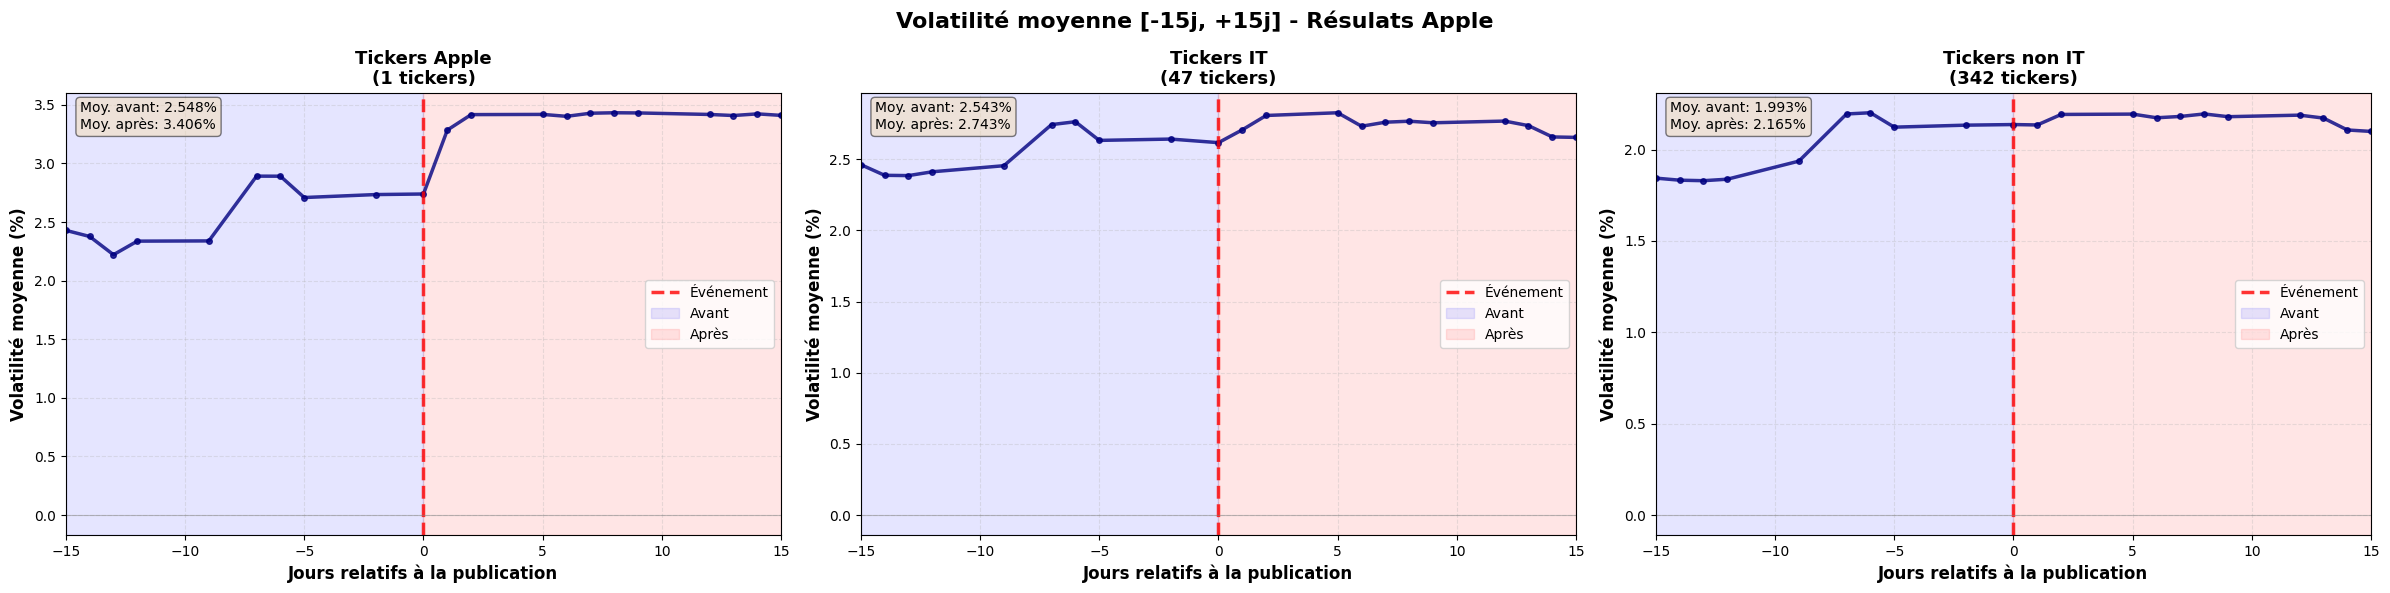

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(24, 6))

# Calculer les rendements quotidiens moyens pour chaque groupe
for idx, (df_subset, label, ax) in enumerate([
    (df_apl, 'Tickers Apple', axes[0]),
    (df_it, 'Tickers IT', axes[1]),
    (df_other, 'Tickers non IT', axes[2])
]):
    # Grouper par date et calculer la moyenne des rendements
    daily_avg_volatility = df_subset.groupby('Date')['Volatilite 20J'].mean() * 100
    
    # Créer un index de jours relatifs à l'événement
    dates = daily_avg_volatility.index.sort_values()
    days_relative = [(d - date_event).days for d in dates]
    
    # Tracer la courbe
    ax.plot(days_relative, daily_avg_volatility.loc[dates].values, 
        linewidth=2.5, color='navy', marker='o', markersize=4, alpha=0.8)
    
    # Ligne verticale pour l'événement
    ax.axvline(x=0, color='red', linestyle='--', linewidth=2.5, 
            label='Événement', alpha=0.8)
    
    # Ligne horizontale à 0
    ax.axhline(y=0, color='gray', linestyle='-', linewidth=0.8, alpha=0.5)
    
    # Zones avant/après colorées
    ax.axvspan(-15, 0, alpha=0.1, color='blue', label='Avant')
    ax.axvspan(0, 15, alpha=0.1, color='red', label='Après')
    
    # Labels et titre
    ax.set_xlabel('Jours relatifs à la publication', fontsize=12, fontweight='bold')
    ax.set_ylabel('Volatilité moyenne (%)', fontsize=12, fontweight='bold')
    ax.set_title(f'{label}\n({len(df_subset["Ticker"].unique())} tickers)', 
                fontsize=13, fontweight='bold')
    
    # Grille et légende
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.legend(loc='best', fontsize=10)
    
    # Limites de l'axe X
    ax.set_xlim(-15, 15)
    
    # Ajouter les statistiques sur le graphique
    mean_before = df_subset[df_subset['Date'] < date_event]['Volatilite 20J'].mean() * 100
    mean_after = df_subset[df_subset['Date'] > date_event]['Volatilite 20J'].mean() * 100
    
    stats_text = f'Moy. avant: {mean_before:.3f}%\nMoy. après: {mean_after:.3f}%'
    ax.text(0.02, 0.98, stats_text, transform=ax.transAxes,
        fontsize=10, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))


# Titre général
fig.suptitle(f'Volatilité moyenne [-15j, +15j] - Résulats Apple',
            fontsize=16, fontweight='bold', y=0.98)


plt.tight_layout()

3. Volume

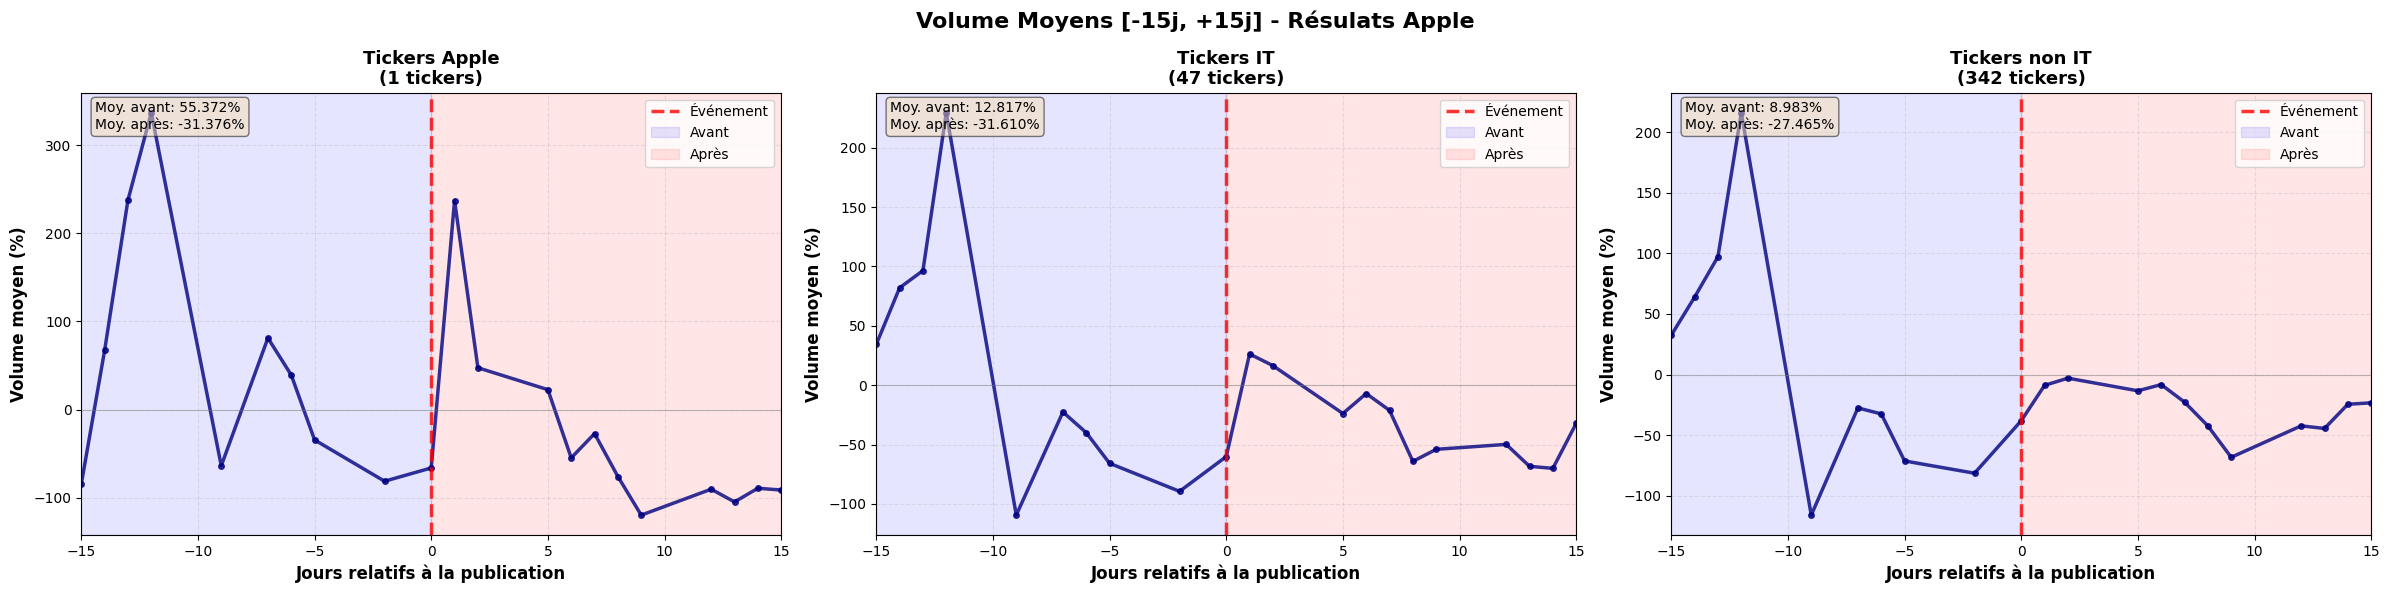

In [28]:
fig, axes = plt.subplots(1, 3, figsize=(24, 6))

# Calculer les rendements quotidiens moyens pour chaque groupe
for idx, (df_subset, label, ax) in enumerate([
    (df_apl, 'Tickers Apple', axes[0]),
    (df_it, 'Tickers IT', axes[1]),
    (df_other, 'Tickers non IT', axes[2])
]):
    # Grouper par date et calculer la moyenne des rendements
    daily_avg_volume = df_subset.groupby('Date')['volume_zscore'].mean() * 100
    
    # Créer un index de jours relatifs à l'événement
    dates = daily_avg_volume.index.sort_values()
    days_relative = [(d - date_event).days for d in dates]
    
    # Tracer la courbe
    ax.plot(days_relative, daily_avg_volume.loc[dates].values, 
        linewidth=2.5, color='navy', marker='o', markersize=4, alpha=0.8)
    
    # Ligne verticale pour l'événement
    ax.axvline(x=0, color='red', linestyle='--', linewidth=2.5, 
            label='Événement', alpha=0.8)
    
    # Ligne horizontale à 0
    ax.axhline(y=0, color='gray', linestyle='-', linewidth=0.8, alpha=0.5)
    
    # Zones avant/après colorées
    ax.axvspan(-15, 0, alpha=0.1, color='blue', label='Avant')
    ax.axvspan(0, 15, alpha=0.1, color='red', label='Après')
    
    # Labels et titre
    ax.set_xlabel('Jours relatifs à la publication', fontsize=12, fontweight='bold')
    ax.set_ylabel('Volume moyen (%)', fontsize=12, fontweight='bold')
    ax.set_title(f'{label}\n({len(df_subset["Ticker"].unique())} tickers)', 
                fontsize=13, fontweight='bold')
    
    # Grille et légende
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.legend(loc='best', fontsize=10)
    
    # Limites de l'axe X
    ax.set_xlim(-15, 15)
    
    # Ajouter les statistiques sur le graphique
    mean_before = df_subset[df_subset['Date'] < date_event]['volume_zscore'].mean() * 100
    mean_after = df_subset[df_subset['Date'] > date_event]['volume_zscore'].mean() * 100
    
    stats_text = f'Moy. avant: {mean_before:.3f}%\nMoy. après: {mean_after:.3f}%'
    ax.text(0.02, 0.98, stats_text, transform=ax.transAxes,
        fontsize=10, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Titre général
fig.suptitle(f'Volume Moyens [-15j, +15j] - {'Résulats Apple'}',
            fontsize=16, fontweight='bold', y=0.98)

plt.tight_layout()

IV / V. Invasion de l’Ukraine par la Russie et Brexit

Comparons cette fois l'impact de ces deux événements pour tous les secteurs.

In [8]:
date_ukrain = pd.to_datetime('2022-02-24')

df_ukrain = df[(df['Date'] >= date_ukrain - pd.Timedelta(days=15)) & (df['Date'] <= date_ukrain + pd.Timedelta(days=15))].copy()

df_before_ukrain = df_ukrain[df_ukrain['Date'] < date_ukrain]
df_after_ukrain = df_ukrain[df_ukrain['Date'] > date_ukrain]

sectors = df_ukrain['Sector'].unique()
results_ukrain = []

for sector in sectors:

    sector_before = df_before_ukrain[df_before_ukrain['Sector'] == sector]
    sector_after = df_after_ukrain[df_after_ukrain['Sector'] == sector]

    # 1. RENDEMENTS
    r1j_before = sector_before['R1J'].mean() * 100
    r1j_after = sector_after['R1J'].mean() * 100
    delta_rendement = r1j_after - r1j_before
    
    # 2. VOLATILITÉ
    vol_before = sector_before['Volatilite 20J'].mean() * 100
    vol_after = sector_after['Volatilite 20J'].mean() * 100
    delta_volatilite = vol_after - vol_before
    ratio_volatilite = (vol_after / vol_before) if vol_before > 0 else 0
    
    # 3. VOLUME (Z-score)
    zscore_before = sector_before['volume_zscore'].mean()
    zscore_after = sector_after['volume_zscore'].mean()
    delta_volume = zscore_after - zscore_before
    
    # Nombre de tickers dans le secteur
    n_tickers = df_ukrain[df_ukrain['Sector'] == sector]['Ticker'].nunique()
    
    results_ukrain.append({
        'Secteur': sector,
        'N_Tickers': n_tickers,
        'Rendement_Avant': r1j_before,
        'Rendement_Apres': r1j_after,
        'Delta_Rendement': delta_rendement,
        'Volatilite_Avant': vol_before,
        'Volatilite_Apres': vol_after,
        'Delta_Volatilite': delta_volatilite,
        'Ratio_Volatilite': ratio_volatilite,
        'Volume_Avant': zscore_before,
        'Volume_Apres': zscore_after,
        'Delta_Volume': delta_volume,
    })

In [9]:
date_brexit = pd.to_datetime('2016-06-23')
df_brexit = df[(df['Date'] >= date_brexit - pd.Timedelta(days=15)) & (df['Date'] <= date_brexit + pd.Timedelta(days=15))].copy()

df_before_brexit = df_brexit[df_brexit['Date'] < date_brexit]
df_after_brexit = df_brexit[df_brexit['Date'] > date_brexit]

sectors = df_brexit['Sector'].unique()
results_brexit = []

for sector in sectors:

    sector_before = df_before_brexit[df_before_brexit['Sector'] == sector]
    sector_after = df_after_brexit[df_after_brexit['Sector'] == sector]

    # 1. RENDEMENTS
    r1j_before = sector_before['R1J'].mean() * 100
    r1j_after = sector_after['R1J'].mean() * 100
    delta_rendement = r1j_after - r1j_before
    
    # 2. VOLATILITÉ
    vol_before = sector_before['Volatilite 20J'].mean() * 100
    vol_after = sector_after['Volatilite 20J'].mean() * 100
    delta_volatilite = vol_after - vol_before
    ratio_volatilite = (vol_after / vol_before) if vol_before > 0 else 0
    
    # 3. VOLUME (Z-score)
    zscore_before = sector_before['volume_zscore'].mean()
    zscore_after = sector_after['volume_zscore'].mean()
    delta_volume = zscore_after - zscore_before
    
    # Nombre de tickers dans le secteur
    n_tickers = df_brexit[df_brexit['Sector'] == sector]['Ticker'].nunique()
    
    results_brexit.append({
        'Secteur': sector,
        'N_Tickers': n_tickers,
        'Rendement_Avant': r1j_before,
        'Rendement_Apres': r1j_after,
        'Delta_Rendement': delta_rendement,
        'Volatilite_Avant': vol_before,
        'Volatilite_Apres': vol_after,
        'Delta_Volatilite': delta_volatilite,
        'Ratio_Volatilite': ratio_volatilite,
        'Volume_Avant': zscore_before,
        'Volume_Apres': zscore_after,
        'Delta_Volume': delta_volume,
    })

In [43]:
sector_colors = {
    'Health Care': '#e74c3c',
    'Information Technology': '#3498db',
    'Financials': '#2ecc71',
    'Consumer Staples': '#f39c12',
    'Industrials': '#9b59b6',
    'Utilities': '#1abc9c',
    'Materials': '#e67e22',
    'Real Estate': '#34495e',
    'Consumer Discretionary': '#16a085',
    'Energy': '#d35400',
    'Communication Services': '#8e44ad'
    }

fig = plt.figure(figsize=(20, 18))
gs = fig.add_gridspec(3, 2, hspace=0.35, wspace=0.25)

<Figure size 2000x1800 with 0 Axes>

1. Returns

In [35]:
# Ukraine
ax1 = fig.add_subplot(gs[0, 0])
df_uk_r = pd.DataFrame(results_ukrain).sort_values('Delta_Rendement', ascending=True)
y_pos = np.arange(len(df_uk_r))
colors = [sector_colors.get(s, '#95a5a6') for s in df_uk_r['Secteur']]

bars = ax1.barh(y_pos, df_uk_r['Delta_Rendement'], 
                color=colors, alpha=0.8, edgecolor='black', linewidth=1.2)

for i, (idx, row) in enumerate(df_uk_r.iterrows()):
    value = row['Delta_Rendement']
    ax1.text(value + (0.02 if value > 0 else -0.02), i, f"{value:.2f}%", 
            va='center', ha='left' if value > 0 else 'right',
            fontsize=9, fontweight='bold')
    
ax1.set_yticks(y_pos)
ax1.set_yticklabels([f"{s} ({n})" for s, n in 
                    zip(df_uk_r['Secteur'], df_uk_r['N_Tickers'])],
                    fontsize=10, fontweight='bold')
ax1.set_xlabel('Δ Rendement moyen (%)', fontsize=12, fontweight='bold')
ax1.set_title('GUERRE EN UKRAINE - Impact sur les Rendements\n(24 février 2022)',
                fontsize=14, fontweight='bold', pad=15)
ax1.grid(True, alpha=0.3, axis='x')
ax1.axvline(x=0, color='black', linewidth=1.5)


# Brexit - Rendements
ax2 = fig.add_subplot(gs[0, 1])
df_br_r = pd.DataFrame(results_brexit).sort_values('Delta_Rendement', ascending=True)
y_pos = np.arange(len(df_br_r))
colors = [sector_colors.get(s, '#95a5a6') for s in df_br_r['Secteur']]

bars = ax2.barh(y_pos, df_br_r['Delta_Rendement'], 
                color=colors, alpha=0.8, edgecolor='black', linewidth=1.2)

for i, (idx, row) in enumerate(df_br_r.iterrows()):
    value = row['Delta_Rendement']
    ax2.text(value + (0.02 if value > 0 else -0.02), i, f"{value:.2f}%", 
            va='center', ha='left' if value > 0 else 'right',
            fontsize=9, fontweight='bold')
    
ax2.set_yticks(y_pos)
ax2.set_yticklabels([f"{s} ({n})" for s, n in 
                    zip(df_br_r['Secteur'], df_br_r['N_Tickers'])],
                    fontsize=10, fontweight='bold')
ax2.set_xlabel('Δ Rendement moyen (%)', fontsize=12, fontweight='bold')
ax2.set_title('BREXIT - Impact sur les Rendements\n(23 juin 2016)',
                fontsize=14, fontweight='bold', pad=15)
ax2.grid(True, alpha=0.3, axis='x')
ax2.axvline(x=0, color='black', linewidth=1.5)

2. Volatilité

In [36]:
# Ukraine
ax3 = fig.add_subplot(gs[1, 0])
df_uk_v = pd.DataFrame(results_ukrain).sort_values('Delta_Volatilite', ascending=True)
y_pos = np.arange(len(df_uk_v))
colors = [sector_colors.get(s, '#95a5a6') for s in df_uk_v['Secteur']]

bars = ax3.barh(y_pos, df_uk_v['Delta_Volatilite'], 
                color=colors, alpha=0.8, edgecolor='black', linewidth=1.2)

for i, (idx, row) in enumerate(df_uk_v.iterrows()):
    value = row['Delta_Volatilite']
    ax3.text(value + (0.5 if value > 0 else -0.5), i, f"{value:.1f}%", 
            va='center', ha='left' if value > 0 else 'right',
            fontsize=9, fontweight='bold')

ax3.set_yticks(y_pos)
ax3.set_yticklabels([f"{s} ({n})" for s, n in 
                    zip(df_uk_v['Secteur'], df_uk_v['N_Tickers'])],
                    fontsize=10, fontweight='bold')
ax3.set_xlabel('Δ Volatilité (%)', fontsize=12, fontweight='bold')
ax3.set_title('GUERRE EN UKRAINE - Impact sur la Volatilité\n(24 février 2022)',
                fontsize=14, fontweight='bold', pad=15)
ax3.grid(True, alpha=0.3, axis='x')
ax3.axvline(x=0, color='black', linewidth=1.5)

# Brexit
ax4 = fig.add_subplot(gs[1, 1])
df_br_v = pd.DataFrame(results_brexit).sort_values('Delta_Volatilite', ascending=True)
y_pos = np.arange(len(df_br_v))
colors = [sector_colors.get(s, '#95a5a6') for s in df_br_v['Secteur']]

bars = ax4.barh(y_pos, df_br_v['Delta_Volatilite'], 
                color=colors, alpha=0.8, edgecolor='black', linewidth=1.2)

for i, (idx, row) in enumerate(df_br_v.iterrows()):
    value = row['Delta_Volatilite']
    ax4.text(value + (0.5 if value > 0 else -0.5), i, f"{value:.1f}%", 
            va='center', ha='left' if value > 0 else 'right',
            fontsize=9, fontweight='bold')

ax4.set_yticks(y_pos)
ax4.set_yticklabels([f"{s} ({n})" for s, n in 
                    zip(df_br_v['Secteur'], df_br_v['N_Tickers'])],
                    fontsize=10, fontweight='bold')
ax4.set_xlabel('Δ Volatilité (%)', fontsize=12, fontweight='bold')
ax4.set_title('BREXIT - Impact sur la Volatilité\n(23 juin 2016)',
                fontsize=14, fontweight='bold', pad=15)
ax4.grid(True, alpha=0.3, axis='x')
ax4.axvline(x=0, color='black', linewidth=1.5)



3. Volume

In [41]:
ax5 = fig.add_subplot(gs[2, 0])
df_uk_vol = pd.DataFrame(results_ukrain).sort_values('Delta_Volume', ascending=True)
y_pos = np.arange(len(df_uk_vol))
colors = [sector_colors.get(s, '#95a5a6') for s in df_uk_vol['Secteur']]

bars = ax5.barh(y_pos, df_uk_vol['Delta_Volume'], 
                color=colors, alpha=0.8, edgecolor='black', linewidth=1.2)

for i, (idx, row) in enumerate(df_uk_vol.iterrows()):
    value = row['Delta_Volume']
    ax5.text(value + (0.1 if value > 0 else -0.1), i, f"{value:.2f}", 
            va='center', ha='left' if value > 0 else 'right',
            fontsize=9, fontweight='bold')

ax5.set_yticks(y_pos)
ax5.set_yticklabels([f"{s} ({n})" for s, n in 
                    zip(df_uk_vol['Secteur'], df_uk_vol['N_Tickers'])],
                    fontsize=10, fontweight='bold')
ax5.set_xlabel('Δ Volume (Z-score)', fontsize=12, fontweight='bold')
ax5.set_title('GUERRE EN UKRAINE - Impact sur le Volume\n(24 février 2022)',
                fontsize=14, fontweight='bold', pad=15)
ax5.grid(True, alpha=0.3, axis='x')
ax5.axvline(x=0, color='black', linewidth=1.5)

# Brexit - Volume
ax6 = fig.add_subplot(gs[2, 1])
df_br_vol = pd.DataFrame(results_brexit).sort_values('Delta_Volume', ascending=True)
y_pos = np.arange(len(df_br_vol))
colors = [sector_colors.get(s, '#95a5a6') for s in df_br_vol['Secteur']]

bars = ax6.barh(y_pos, df_br_vol['Delta_Volume'], 
                color=colors, alpha=0.8, edgecolor='black', linewidth=1.2)

for i, (idx, row) in enumerate(df_br_vol.iterrows()):
    value = row['Delta_Volume']
    ax6.text(value + (0.1 if value > 0 else -0.1), i, f"{value:.2f}", 
            va='center', ha='left' if value > 0 else 'right',
            fontsize=9, fontweight='bold')

ax6.set_yticks(y_pos)
ax6.set_yticklabels([f"{s} ({n})" for s, n in 
                    zip(df_br_vol['Secteur'], df_br_vol['N_Tickers'])],
                    fontsize=10, fontweight='bold')
ax6.set_xlabel('Δ Volume (Z-score)', fontsize=12, fontweight='bold')
ax6.set_title('BREXIT - Impact sur le Volume\n(23 juin 2016)',
                fontsize=14, fontweight='bold', pad=15)
ax6.grid(True, alpha=0.3, axis='x')
ax6.axvline(x=0, color='black', linewidth=1.5)



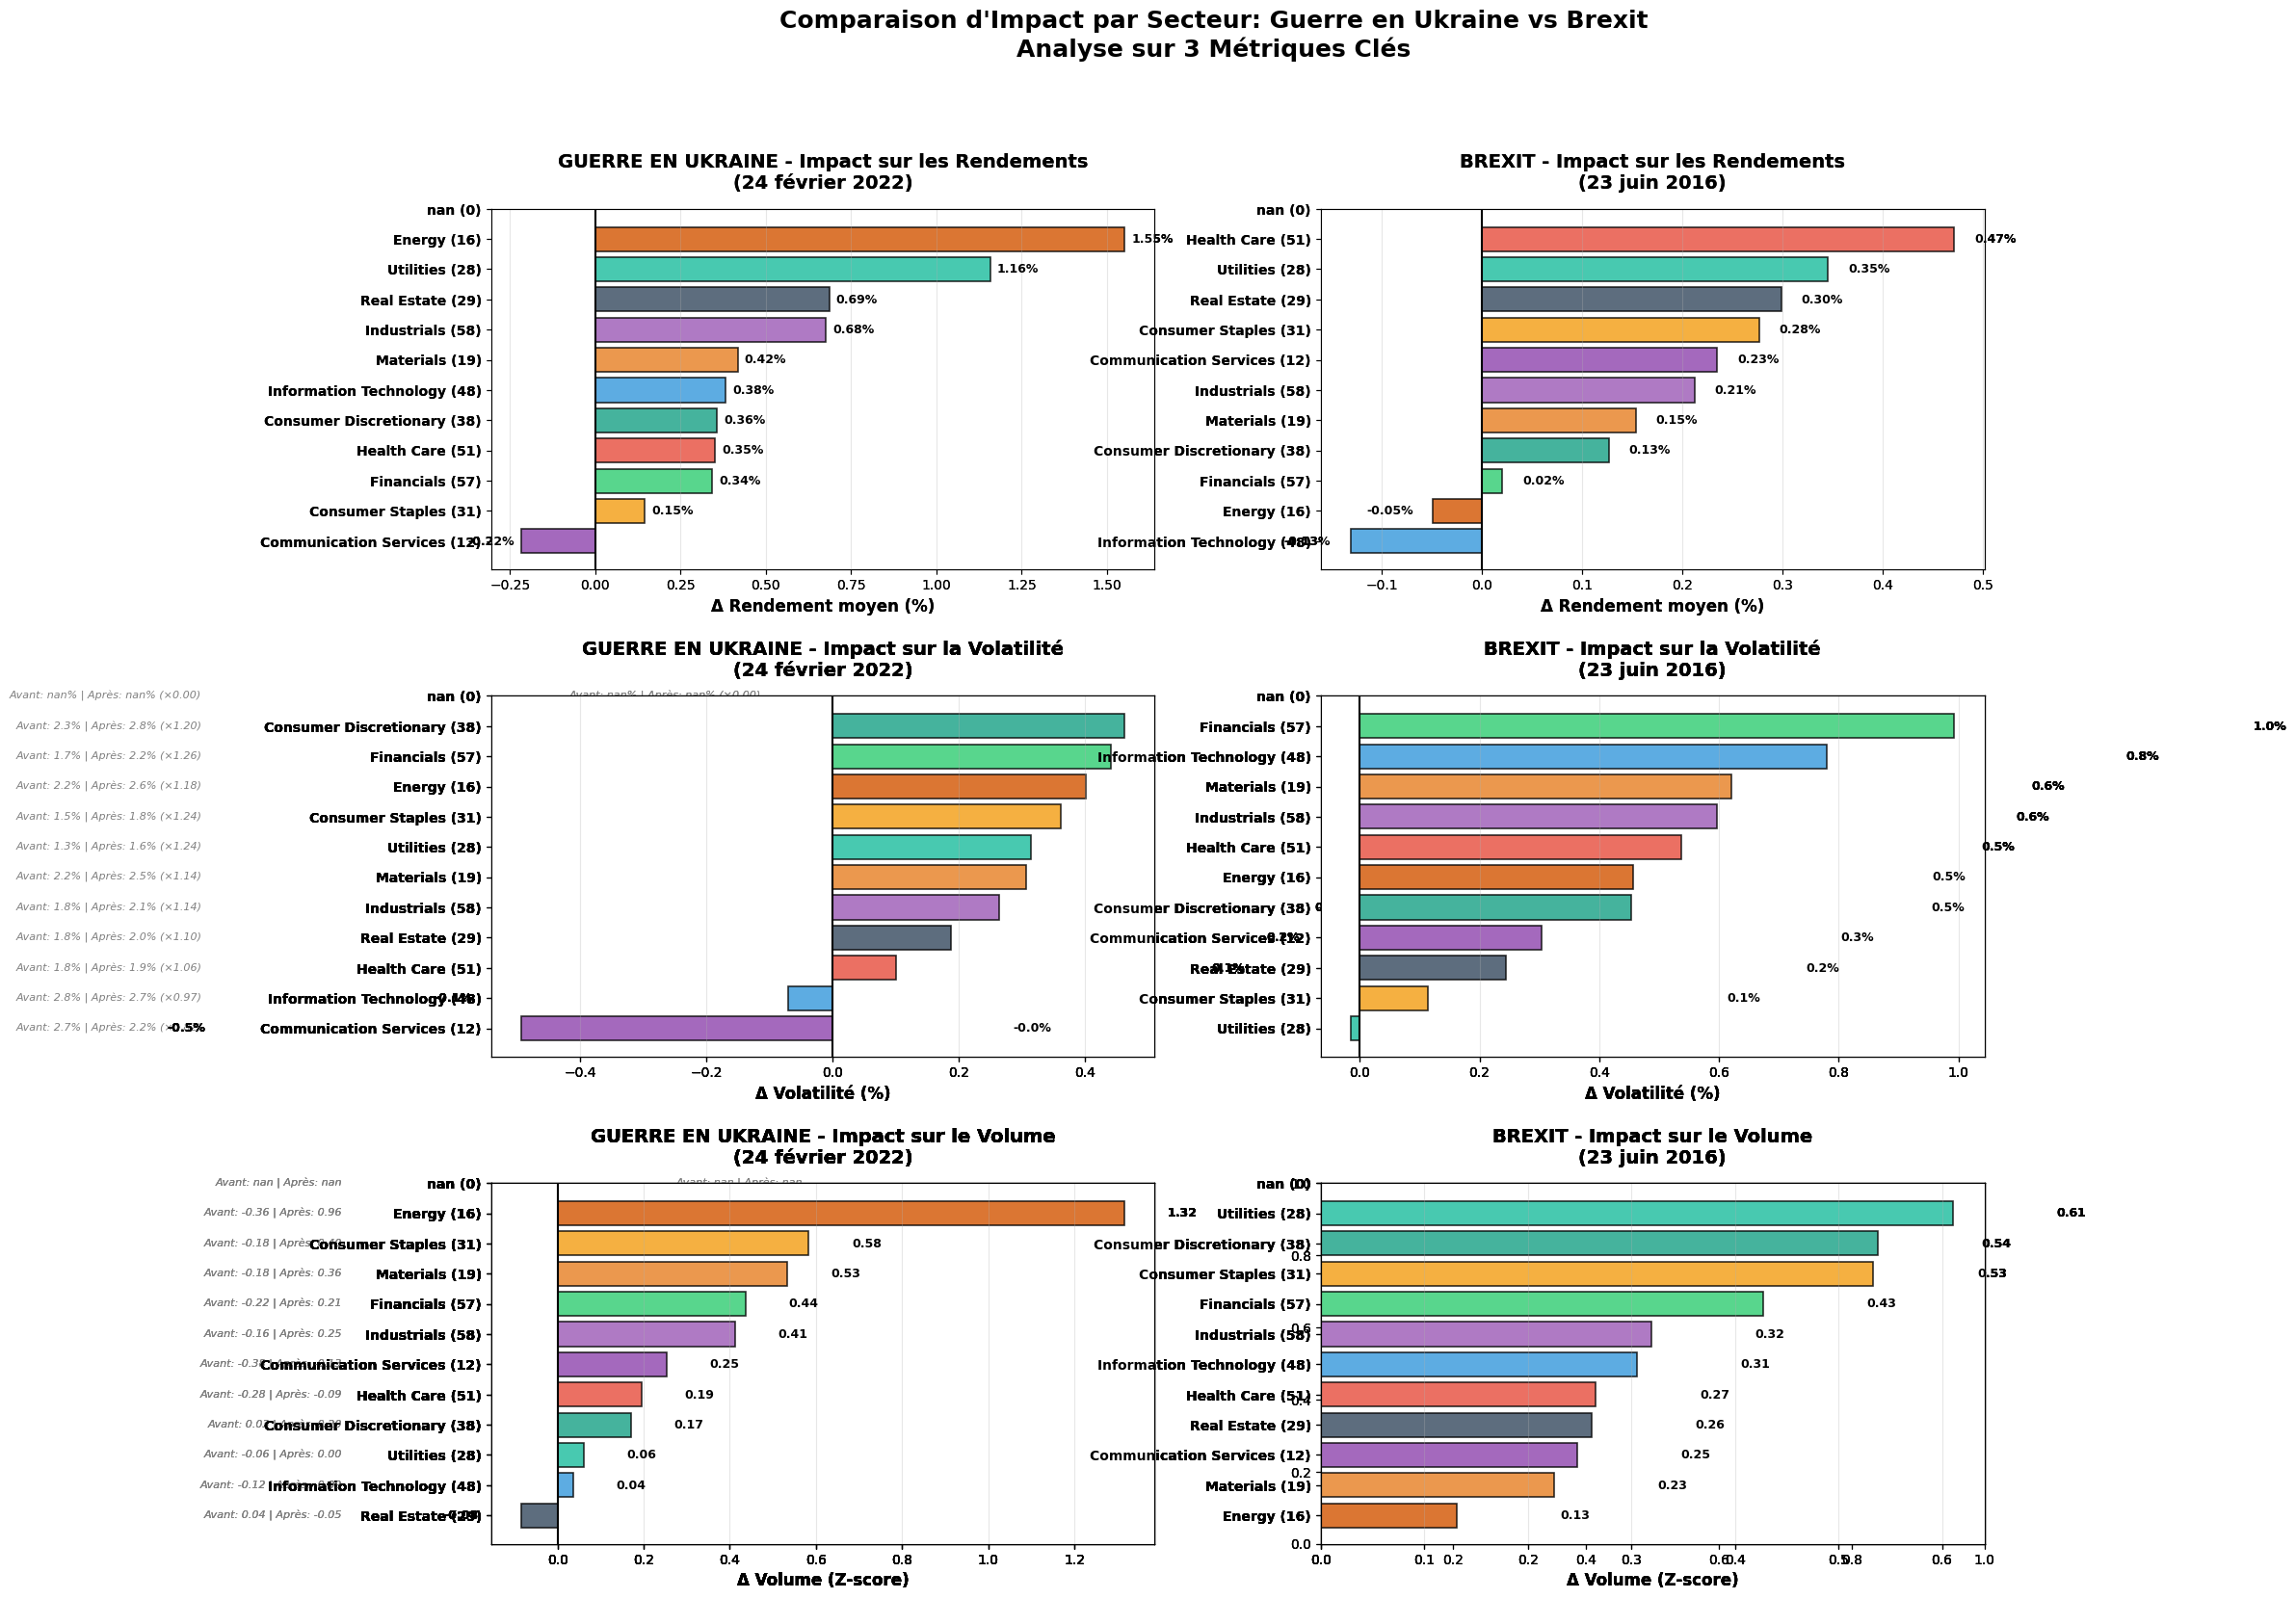

In [42]:
fig.suptitle('Comparaison d\'Impact par Secteur: Guerre en Ukraine vs Brexit\nAnalyse sur 3 Métriques Clés',
            fontsize=18, fontweight='bold', y=0.995)
fig